# Eigenfarms
* Method to add value to networks
* A way to Spatial Simplify large geospatial datasets
* Provide Rankings
* Looks at clustering

## Imports

In [3]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
def convert_GeoPandas_to_Bokeh_format(gdf):
    """
    Function to convert a GeoPandas GeoDataFrame to a Bokeh
    ColumnDataSource object.
    
    :param: (GeoDataFrame) gdf: GeoPandas GeoDataFrame with polygon(s) under
                                the column name 'geometry.'
                                
    :return: ColumnDataSource for Bokeh.
    """
    gdf_new = gdf.drop('geometry', axis=1).copy()
    gdf_new['x'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='x', 
                             shape_type='polygon', 
                             axis=1)
    
    gdf_new['y'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='y', 
                             shape_type='polygon', 
                             axis=1)
    
    return ColumnDataSource(gdf_new)

In [5]:
def getGeometryCoords(row, geom, coord_type, shape_type):
    """
    Returns the coordinates ('x' or 'y') of edges of a Polygon exterior.
    
    :param: (GeoPandas Series) row : The row of each of the GeoPandas DataFrame.
    :param: (str) geom : The column name.
    :param: (str) coord_type : Whether it's 'x' or 'y' coordinate.
    :param: (str) shape_type
    """
    
    # Parse the exterior of the coordinate
    if shape_type == 'polygon':
        exterior = row[geom].exterior
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return list( exterior.coords.xy[0] )    
        
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( exterior.coords.xy[1] )

    elif shape_type == 'point':
        exterior = row[geom]
    
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return  exterior.coords.xy[0][0] 

        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return  exterior.coords.xy[1][0]

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import ancil_load
import ancil_analytics
import datetime as dt
import ancil_bokeh

ancil_load=reload(ancil_load)
ancil_analytics=reload(ancil_analytics)
ancil_bokeh=reload(ancil_bokeh)

## Loading generation (subtract means)

In [7]:
df_all_ancil,price = ancil_load.SA_production_price()
df_all_ancil["index"]=df_all_ancil.index
df_all_ancil=df_all_ancil.drop_duplicates("index")
df_all_ancil=df_all_ancil.drop("index",axis=1)
df_all_ancil=df_all_ancil.fillna(0)

price=pd.DataFrame(price)
price["index"]=price.index
price=price.drop_duplicates("index")
price=price.drop("index",axis=1)
#price=price.iloc[1::2]
# price=pd.Series(price)

df_all=df_all_ancil.loc[dt.datetime(2016,12,1):dt.datetime(2017,2,28)]

# subtract mean if we are looking for mxm or the U
#df=df-df.mean(axis=1)
# subtract mean if we are looking for nxn or the V
dfmean=df_all.mean(axis=0)
df=df_all.subtract(dfmean)

## Calculate SVD

In [8]:
# Can be a slow step or kill the computer
u,s,v=np.linalg.svd(df)

## Project onto eigenvectos -> m points on pc plot -> can filter

In [9]:
# making all the principal components
principle = pd.DataFrame()
for i in range(v.shape[0]):
    principle["PC{0}".format(i+1)]=v[i,:]
    

In [10]:
PC1=v[0,:]
PC2=v[1,:]
PC3=v[2,:]

# C is the projecitons in time onto the eignvectr
C1=np.dot(df,PC1)
C2=np.dot(df,PC2)
C3=np.dot(df,PC3)

PCA=pd.DataFrame({"PC1":C1,"PC2":C2,"PC3":C3},index=df.index)
PCA["timestamp"]=PCA.index
PCA["month"]=np.array(np.array(PCA.index.month))
PCA["day"]=np.array(np.array(PCA.index.day))
PCA["hour"]=np.array(np.array(PCA.index.hour))


import seaborn as sns
### Optional Plot
# # PCA1 Vs PC2
# sns.lmplot(data=PCA,x="PC1",y="PC2",hue="gen",fit_reg=False)
# sns.lmplot(data=PCA,x="PC1",y="PC2",hue="Geography",fit_reg=False)

# # PCA1 VC PC3
# sns.lmplot(data=PCA,x="PC1",y="PC3",hue="gen",fit_reg=False)
# sns.lmplot(data=PCA,x="PC1",y="PC3",hue="Geography",fit_reg=False)

# # Looking at timeseries underneath
# df[["SNOWNTH1","HDWF3","CLEMGPWF","LKBONNY2"]].plot()

# PCPlot

In [11]:
# Price filter
price=price.dropna()
price=price.loc[df_all.index]
p80=np.percentile(np.array(price["SA"]),80)
p95=np.percentile(np.array(price["SA"]),95)
p10=np.percentile(np.array(price["SA"]),10)
price_high=price.loc[price["SA"]>p80]
price_extreme=price.loc[price["SA"]>p95]
price_low=price.loc[price["SA"]<p10]

# productioin filter

wind=df_all.sum(axis=1)
p80=np.percentile(np.array(wind),80)
p95=np.percentile(np.array(wind),95)
p10=np.percentile(np.array(wind),10)
wind_high=wind.loc[wind>p80]
wind_extreme=wind.loc[wind>p95]
wind_low=wind.loc[wind<p10]

In [12]:
PCA["high"]=0
PCA["high"].loc[price_high.index]=1
PCA["high"].loc[price_extreme.index]=99

PCA["low"]=0
PCA["low"].loc[price_low.index]=1


#---
PCA["Wind"]=0
PCA["Wind"].loc[wind_high.index]=1
PCA["Wind"].loc[wind_extreme.index]=99
PCA["Wind"].loc[wind_low.index]=200






/home/peterad/.local/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
mPCA=pd.melt(PCA,value_vars=["PC1","PC2","PC3"],id_vars=["Wind"])

In [21]:
mPCA

,Wind,variable,value
0,0,PC1,-78.664213
1,0,PC1,-93.279946
2,0,PC1,-104.497989
3,200,PC1,-109.763913
4,200,PC1,-113.024433
5,200,PC1,-114.824159
6,200,PC1,-117.248530
7,200,PC1,-118.389985
8,200,PC1,-118.887620
9,200,PC1,-118.368620


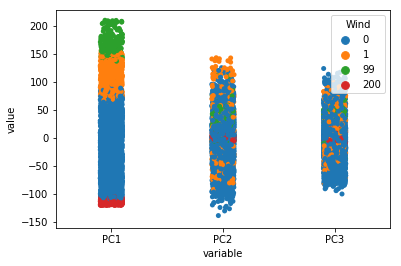

In [27]:
# Todo to motivate
# need to MElt

sns.stripplot(data=mPCA,x="variable",y="value",hue="Wind",jitter=True)

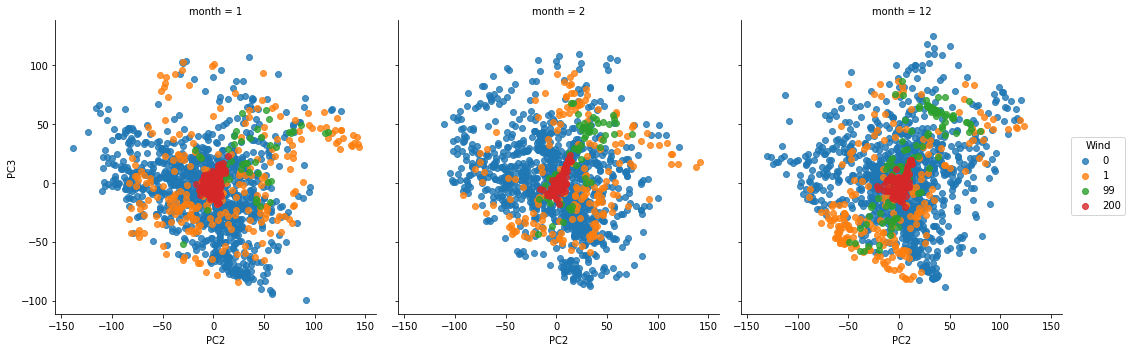

In [15]:
ax=sns.lmplot(data=PCA,x="PC2",y="PC3",hue="Wind",col="month",col_wrap=3,fit_reg=False)

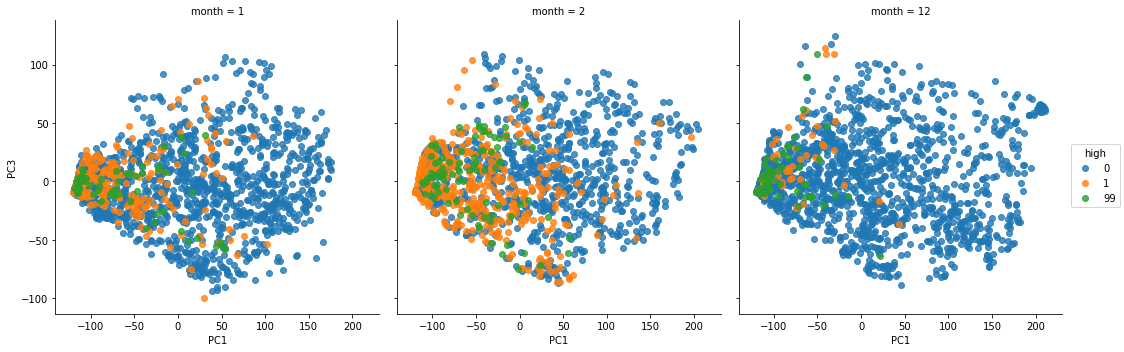

In [34]:
ax=sns.lmplot(data=PCA,x="PC1",y="PC3",hue="high",col="month",col_wrap=3,fit_reg=False)

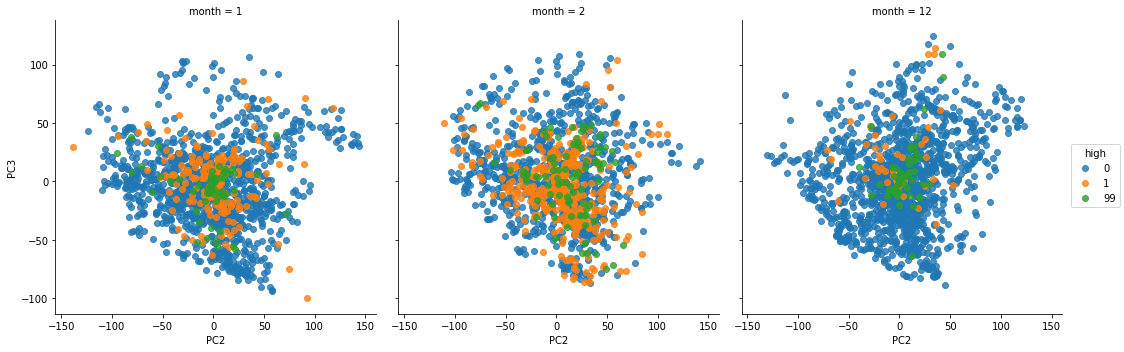

In [31]:
ax=sns.lmplot(data=PCA,x="PC2",y="PC3",hue="high",col="month",col_wrap=3,fit_reg=False)

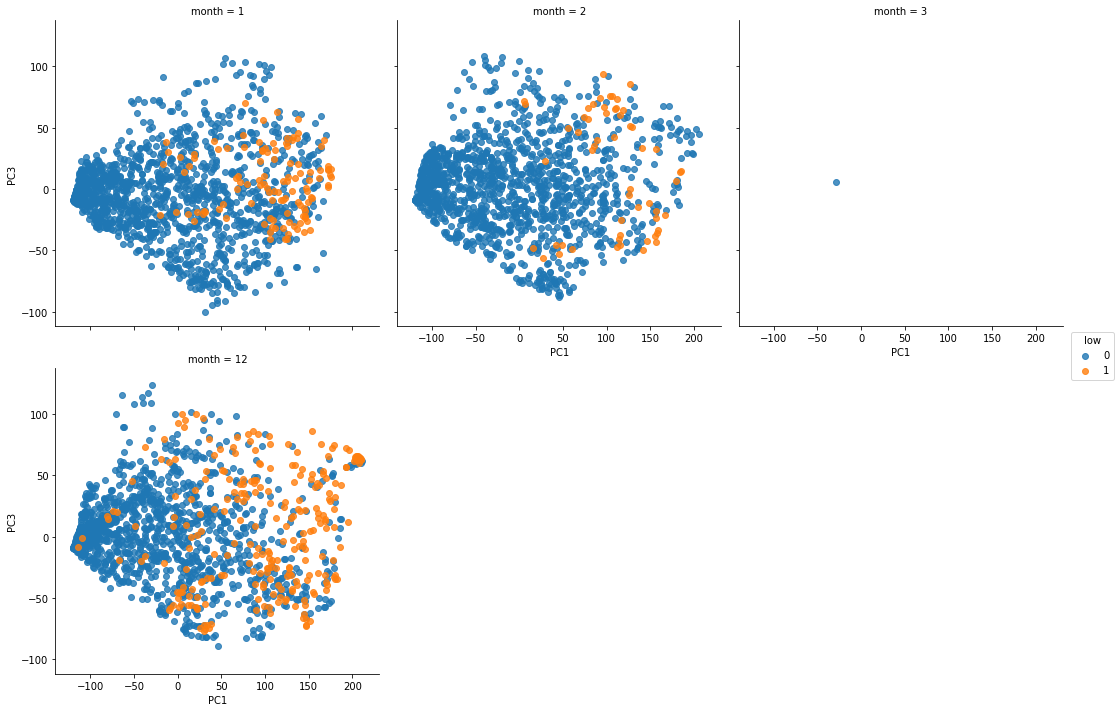

In [23]:
# Monthly
import seaborn as sns
ax=sns.lmplot(data=PCA,x="PC1",y="PC3",hue="low",col="month",col_wrap=3,fit_reg=False)


In [ ]:
# Extreme price 

## Mapping fisrt Eigenwindfarm loadings onto geospatial

In [15]:
# Very Nice tutorial on using geospatial data
# http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/

In [16]:
import geopandas as gpd
base=gpd.read_file("/mnt/y/Data/geospatial/sa_lga_polygon_shp/SA_LGA_POLYGON_shp/")

In [17]:
import geopandas
from shapely.geometry import Point

list(df.columns)
geolocate=pd.read_excel("/mnt/y/Data/Electricity/Generatorinfo/AEMO/SA_location_date.xlsx")
geolocate.index=geolocate["Wind Farm"]
geolocate=geolocate.loc[df.columns]


# fiddle with this to force it to be between 0 and 1
geolocate["PC1"]=PC1
geolocate["PC1_r"]=abs(PC1*.3)

geolocate["PC2"]=PC2
geolocate["PC2_r"]=abs(PC2*.3)

geolocate["PC3"]=PC3
geolocate["PC3_r"]=abs(PC3*.3)

geolocate['Coordinates']=list(zip(geolocate.Longitude,geolocate.Latitude))
geolocate["Coordinates"]=geolocate["Coordinates"].apply(Point)
geolocate=geopandas.GeoDataFrame(geolocate,geometry='Coordinates')

# ax=base.plot()
# locate.plot(ax=ax,color="red")


In [18]:
from bokeh.palettes import Viridis256, RdYlBu

In [33]:
geolocate

,Wind Farm,Location,Year entered,month,Latitude,Longitude,PC1,PC1_r,PC2,PC2_r,PC3,PC3_r,Coordinates
HALLWF1,HALLWF1,North,2008,6,-33.339734,138.732332,0.251385,0.075415,0.213990,0.064197,-0.121861,0.036558,POINT (138.7323317 -33.33973358)
SNOWNTH1,SNOWNTH1,Jamestown,2014,3,-33.721520,138.147088,0.415196,0.124559,-0.510342,0.153103,0.203828,0.061148,POINT (138.1470884 -33.72152007)
HALLWF2,HALLWF2,North,2010,5,-33.522602,138.855160,0.213580,0.064074,0.125199,0.037560,-0.084957,0.025487,POINT (138.8551598 -33.52260244)
WATERLWF,WATERLWF,Central,2010,9,-34.001025,138.910932,0.314888,0.094466,0.252901,0.075870,-0.076063,0.022819,POINT (138.9109315 -34.00102479)
BLUFF1,BLUFF1,North,2012,3,-33.385546,138.792832,0.105050,0.031515,0.076509,0.022953,0.017488,0.005246,POINT (138.7928315 -33.38554626)
LKBONNY3,LKBONNY3,South,2010,7,-37.750496,140.393029,0.053551,0.016065,0.106604,0.031981,0.180098,0.054029,POINT (140.3930292 -37.75049632)
LKBONNY2,LKBONNY2,South,2010,1,-37.814894,140.419499,0.234511,0.070353,0.464947,0.139484,0.794628,0.238388,POINT (140.4194991 -37.81489402)
NBHWF1,NBHWF1,North,2011,5,-33.309260,138.729595,0.372533,0.111760,0.289711,0.086913,-0.359529,0.107859,POINT (138.7295955 -33.30925994)
CLEMGPWF,CLEMGPWF,Jamestown,2010,1,-33.508568,138.119175,0.162680,0.048804,-0.051639,0.015492,-0.087743,0.026323,POINT (138.1191752 -33.50856771)
HDWF1,HDWF1,Jamestown,2016,7,-33.085760,138.522000,0.331596,0.099479,0.247261,0.074178,-0.342272,0.102681,POINT (138.522 -33.08576)


In [19]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_file, show
from bokeh.plotting import figure
ancil_bokeh=reload(ancil_bokeh)

output_file("slider.html")

tabs=[]
for i in range(1,4):
    
    title = "Distribution for Principal {0}".format(i)
    bokeh_frame=ancil_bokeh.bokeh_PCA(geolocate,i,title)
    f1 = figure(plot_width=300, plot_height=300)
    tabs.append(Panel(child=bokeh_frame,title=title))

tabs=Tabs(tabs=tabs)
    
    
show(tabs)



# Put in WMTS tile sources

In [29]:
%matplotlib notebook

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
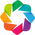

In [30]:
# Need the geolocation of windfarms!
import xarray as xr
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf

import cartopy
from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')


tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
         'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
         'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
         'Stamen Toner': STAMEN_TONER}


In [31]:
locate=geolocate.drop("Coordinates",axis=1)
locate=pd.DataFrame(locate)
g_locate=gv.Dataset(locate,kdims=["Location"])

NameError: name 'geolocate' is not defined

# PC1

In [ ]:
%%opts Overlay [width=1000 height=800] 
%%opts Points (size=40 cmap='RdYlBu') [tools=['hover'] size_index="PC1" color_index="PC1" xaxis=None yaxis=None]

holo=(gv.WMTS(tiles['Wikipedia']) * g_locate.to(gv.Points
                                         ,kdims=['Longitude', 'Latitude'],vdims=['Location',"PC1","PC2","PC3"], crs=ccrs.PlateCarree()))



# PC2

In [ ]:
%%opts Overlay [width=1000 height=800] 
%%opts Points (size=40 cmap='RdYlBu') [tools=['hover'] size_index="PC2" color_index="PC2" xaxis=None yaxis=None]

holo=(gv.WMTS(tiles['Wikipedia']) * g_locate.to(gv.Points
                                         ,kdims=['Longitude', 'Latitude'],vdims=['Location',"PC1","PC2","PC3"], crs=ccrs.PlateCarree()))


# PC3

In [ ]:
%%opts Overlay [width=1000 height=800] 
%%opts Points (size=40 cmap='RdYlBu') [tools=['hover'] size_index="PC3" color_index="PC3" xaxis=None yaxis=None]

holo=(gv.WMTS(tiles['Wikipedia']) * g_locate.to(gv.Points
                                         ,kdims=['Longitude', 'Latitude'],vdims=['Location',"PC1","PC2","PC3"], crs=ccrs.PlateCarree()))


## Map the first Eigenwindfarm combintation onto timeseries

principle is dataframe with loadings, aka columns of V

In [ ]:
# As per https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

In [223]:
projZ=np.dot(df,principle.iloc[:,:2])
df_proj=np.dot(projZ,(principle.iloc[:,:2]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns

df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index

<IPython.core.display.Javascript object>


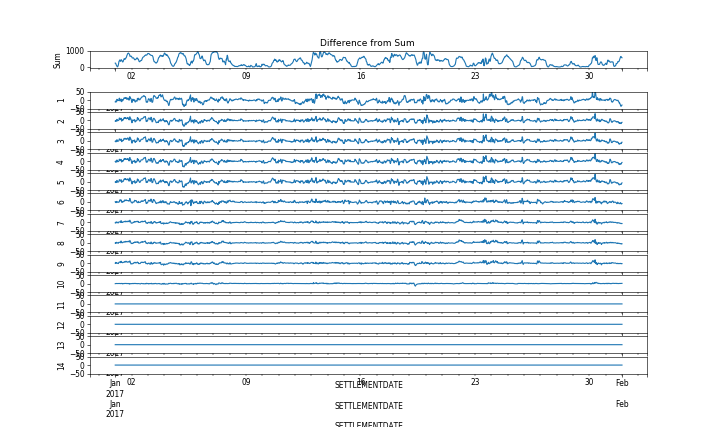

In [242]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.subplot(16,1,1)
plt.title("Difference from Sum ")
df_all.sum(axis=1).plot()
plt.ylabel("Sum")
#plt.rotation(90)
for i in range(2,16):
    plt.subplot(16,1,i+1)
    # aggregating nth PC
    projZ=np.dot(df,principle.iloc[:,:i])
    df_proj=np.dot(projZ,(principle.iloc[:,:i]).T)
    df_proj=pd.DataFrame(df_proj)
    df_proj.columns=df.columns
    df_proj=df_proj.add(dfmean,axis=1)
    df_proj.index=df.index
    (df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
    plt.ylim((-50,50))
    plt.ylabel(i-1)

In [207]:
plt.show()

## First PC

In [ ]:
df_proj=np.dot(projZ,(principle.iloc[:,:]).T)

<IPython.core.display.Javascript object>


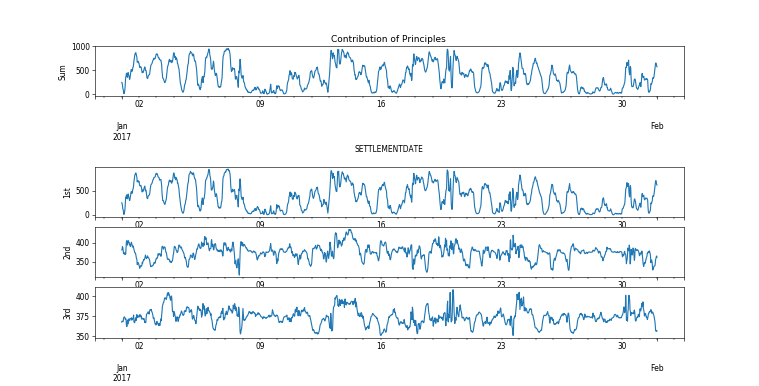

Text(0,0.5,'3rd')

In [255]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.subplot(5,1,1)
plt.title("Contribution of Principles ")
df_all.sum(axis=1).plot()
plt.ylabel("Sum")
#plt.rotation(90)

# First 
plt.subplot(5,1,3)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,0:1])
df_proj=np.dot(projZ,(principle.iloc[:,0:1]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("1st")

# Second
plt.subplot(5,1,4)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,1:2])
df_proj=np.dot(projZ,(principle.iloc[:,1:2]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("2nd")


# Third
plt.subplot(5,1,5)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,2:3])
df_proj=np.dot(projZ,(principle.iloc[:,2:3]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("3rd")

## Second PC

## Third PC

# My best guess how to do it: suspect I am plotting something very different

In [124]:
timeseries=pd.DataFrame()
for i in range(df.shape[1]):
    timeseries["timeseries{0}".format(i+1)]=np.array(df.multiply(np.array(principle["PC{0}".format(i+1)]),axis=1)).sum(axis=1)
timeseries.index = df.index

In [125]:
%matplotlib notebook

<IPython.core.display.Javascript object>


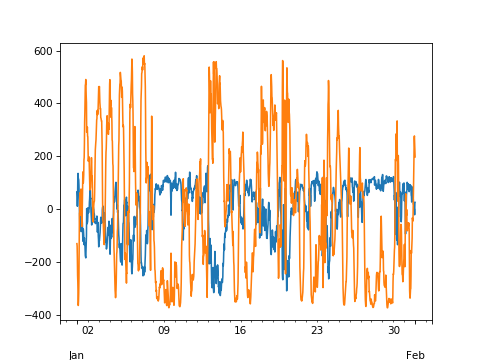

In [130]:
timeseries.sum(axis=1).plot()
df.sum(axis=1).plot()

<IPython.core.display.Javascript object>


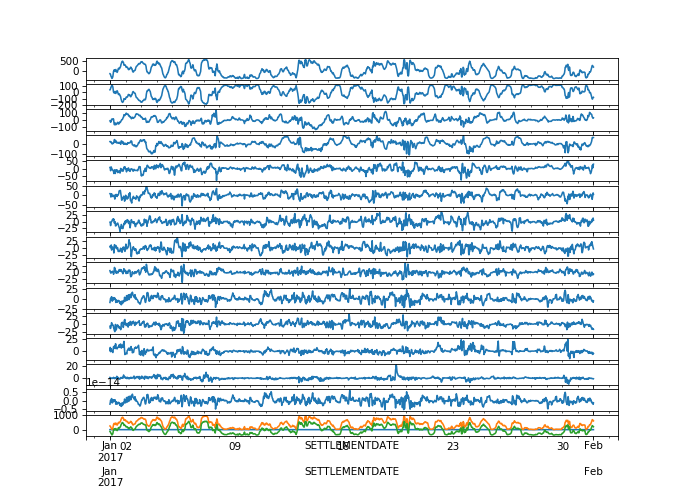

In [131]:
import matplotlib.pyplot as plt
plt.subplot(15,1,1)
df.sum(axis=1).plot()
for i in range(1,15):
    plt.subplot(15,1,i+1)
    timeseries.iloc[:,i-1].plot()


# Appendix

## Testing to get tabs with PCA geoplots

In [ ]:
%%opts Overlay [width=1000 height=800] 
%%opts Points (size=5.0 cmap='viridis') [tools=['hover'] size_index=2 color_index=2 xaxis=None yaxis=None]

holo=(gv.WMTS(tiles['Wikipedia']) * g_locate.to(gv.Points, kdims=['Longitude', 'Latitude'],vdims=['Location',"PC1","PC2","PC3"], crs=ccrs.PlateCarree()))
#bokeh= renderer.get_plot(holo)


# from bokeh.models.widgets import Panel, Tabs
# from bokeh.io import output_file, show
# from bokeh.plotting import figure

# output_file("slider.html")

# tabs=[]
# for i in range(1,4):
    
#     title = "Distribution for Principal {0}".format(i)
#     bokeh_frame=ancil_bokeh.bokeh_PCA(geolocate,i,title)
#     f1 = figure(plot_width=300, plot_height=300)
#     tabs.append(Panel(child=bokeh_frame,title=title))

# tabs=Tabs(tabs=tabs)
    
    
# show(tabs)
